In [8]:
class Gibbs_free_energy:
    
    """Based on a predetermined bulk solution, this code can calculate the gibbs free energy of various reactions. Made by Dylan Verburg in april 2022"""
    
    def __init__(self, bulk_solution):
        import numpy as np
        import matplotlib.pyplot as plt
        import pandas as pd
        #bulk solution is denoted in pandas dataframe
        #entropies are based on the file below
        self.energies = pd.read_csv('entropy_enthalpy_table.csv', skiprows=[1], skipinitialspace=True, index_col=0)
        self.R = 8.314/1000 #kJ/mol K
        self.Ts = 298.15 #K
        self.bulk_solution = bulk_solution  #assume this to be a dataframe
    
### interface functions ###
    def read_reaction(self, reaction, undefined_concentrations, warnings = True):
        #undefined_concentrations = 1
        #initialize the lists
        stoichiometry = np.array([0])
        compound = np.array(['0'])
        concentration = np.array([0])
        gas = np.array([0])
        
        
        reaction_sides = reaction.split('-->') #split right and left hand side of equation
        
        for i in range(len(reaction_sides)): #this is for the two sides of the equation, but more would work aswell
            reaction_compounds = reaction_sides[i].split(' + ') #split compounds
            
            for j in range(len(reaction_compounds)):
                reaction_pure_compound = reaction_compounds[j].split('*') #see if there is one or more mole of the compound in the reaction
                
                if(len(reaction_pure_compound) == 1): #if there is nothing written in front of the material, assume it should be 1 and assume concentration to be 1
                    reaction_pure_compound = [1.0, reaction_compounds[j]]
               
                stoichiometry = np.append(stoichiometry, float(reaction_pure_compound[0]) * (-1.0)**(i + 1)) #make the stoichiometric variable positive or negative based on the side of the equation
                compound = np.append(compound, reaction_pure_compound[1].replace(" ", ""))
                
                gas = np.append(gas, reaction_pure_compound[1].find("(g)") <= 0) #is this a gas or not
                #add a concentration provided in the bulk, and prevent errors if it is not provided
                try:
                    concentration = np.append(concentration, self.bulk_solution.loc[compound[-1]])
                except:
                    concentration = np.append(concentration, undefined_concentrations)
                    if warnings == True:
                        print(f'No concentration for {reaction_pure_compound[1]} was found. It was set to {undefined_concentrations}')
                
        #put everything in a pandas dataframe for easier lookup accros tables
        reaction_full = pd.DataFrame(list(zip(stoichiometry, concentration)), index = compound, columns = ['Stoichiometry','Concentration'], dtype = float)
        
        reaction_full["Gas"] = gas
        reaction_full = reaction_full.drop('0')
        
        return reaction_full
    
    def check_reaction(self, reaction): ##doesn't work##
        #This function checks if the provided reactions are balanced
        reaction_matrix = self.read_reaction(reaction, 1, warnings = False)
        
        #define some lists and the list to work on
        compound_list = []
        value_list = []
        
        #iterate through the compounds in the reaction, drop the phase and the charge of these aswell
        for compound in range(len(reaction_matrix)):
            find = reaction_matrix.index[compound]
            
            #drop phase
            b = find.find('(')
            text = find[0:b]
            #drop charge
            text = text.replace("-","")
            text = text.replace("+","")

            #this takes the scrubbed compounds and finds the capital letters, this allows for simple compounds like 'H', for hydrogen, but also 'Ca' for calcium to be balanced
            d = ''.join(' ' + char if char.isupper() else char.strip() for char in text).strip().split(" ")
            
            #iterate through all these parts of a compound, some like CO2 have no number next to the C, 
            #the try, excpet structure deals with this and appends the stoichiometric value of a compound to a list, as well as the compound itself
            for i in range(len(d)):
                try: 
                    e = float(d[i][-1]) * a.Stoichiometry[compound]
                    name = d[i][0:-1]
                except: 
                    e = reaction_matrix.Stoichiometry[compound]
                    name = d[i][:]
                    
                compound_list.append(name) 
                value_list.append(e)
                
        #once all compounds have been added, the unique compounds are put in a list to which a parralel list for bookkeeping is made
        unique = list(set(compound_list))
        values_unique = [0] * len(unique)

        #find the index of the compound in the unique list, add the stoichiometry to the values list
        for p in range(len(compound_list)):
            index = unique.index(compound_list[p])
            values_unique[index] += value_list[p]
        
        #find all non_zero values in the list, these are thus not balanced
        missing_index = np.nonzero(values_unique)[0]
        
        #give human readable output for both the case of balance, and impabalnce
        if len(missing_index) > 0:
            print(f'Non balanced reaction, missing:')
            for i in range(len(missing_index)):
                print(f'{values_unique[missing_index[i]]} {unique[missing_index[i]]}')
        else: print('Balanced reaction')
        
### Thermodynamic functions ###
    def define_G(self, reaction_matrix):
        #This function gives the initial G and H values
        #initialize
        dH = 0
        dG = 0
        
        #find in provided matrix of gibbs energies
        for i in range(len(reaction_matrix)):
            Gibbs_values = self.energies.loc[reaction_matrix.index[i], :] #find the dH and dS values
            
            #combine the energies to gain a reaction energy
            dH += reaction_matrix.Stoichiometry[i] * float(Gibbs_values[0])
            dG += reaction_matrix.Stoichiometry[i] * float(Gibbs_values[2])        
        return dG, dH
    
    def T_C_comp_linear(self, reaction_matrix, d_G0S, d_H0S, T):
        #T compensation for a range of T in K, as well as concentration compensation based on the bulk solution and gasses       
        #concentration compensation for gasses and non-gasses on the same range of T        
        reaction_matrix["mult"] = reaction_matrix.Stoichiometry * np.log(reaction_matrix.Concentration) 
        
        non_gasses = reaction_matrix.mult[reaction_matrix.Gas > 0].sum(axis=0)
        gasses = reaction_matrix.mult[reaction_matrix.Gas == 0].sum(axis=0) 
        
        #gasses should be in b but that doesn't seem to work
        #This is based on shuffeling the Gibbs free energy calculation into making it a linear function in T, provided the concentrations do not change
        a = self.R * (gasses + non_gasses) + (d_G0S - d_H0S) / self.Ts
        b =  d_H0S #+ gasses
        
        # coeficients for certain concentrations, this makes simulating a temprature range more memory efficient
        return a , b

    def give_for_T(self, reaction, T = [-1], undefined_concentrations = 1, warnings = True):
        #allows the user to ask for the gibbs energy at a certain temprature, or range of tempratures
        reaction_matrix = self.read_reaction(reaction, undefined_concentrations, warnings)
        
        #provides easy way to provide dG for standard temprature (298.15K), just used for easy interaction
        if(T[-1]<0):
            T = self.Ts
        
        #find the standard T, G and H values
        dG, dH = self.define_G(reaction_matrix)
        #feed these to the T and concentration compensation function
        a, b = self.T_C_comp_linear(reaction_matrix, dG, dH, T)
        #create the array based on the temprature fed into the function
        dGT = a * np.array(T) + b
        return dGT
    
    def thin_film(self, reaction_matrix, T, C_diff = 0.1, steps = 11):
        #Basic code to resemble difussion driven change in substrate and products by changing the concentration over time  
        a_row = []
        b_row = []
        c_row = []
        concentration_row = []
        
        Concentrations= reaction_matrix.Concentration.tolist()
        #molar difference based on a percentage of the first compound
        diff = (reaction_matrix.Concentration.iloc[0] * C_diff / reaction_matrix.Stoichiometry[0]) * reaction_matrix.Stoichiometry
        concentration_row.append(Concentrations)
        
        d_G0s, d_H0s = self.define_G(reaction_matrix)
  
        for i in range(steps):
            a, b = self.T_C_comp_linear(reaction_matrix, d_G0s, d_H0s, T)
            
            a_row.append(a)
            b_row.append(b)
            c_row.append(round(C_diff * i, 3))
            
            #change the concentration of reaction products and substrates, the idea is to decrease the concentration with 10% (C_diff) per step (steps) for the whole reaction, thus stoichiometry plays a role
            Concentrations -= diff
            #prevent negative concentrations
            Concentrations[Concentrations < 0] = 1e-11
            
            concentration_row.append(Concentrations.tolist())
            reaction_matrix.Concentration = Concentrations
            
        return np.array(a_row), np.array(b_row), np.array(c_row), concentration_row

### Visual functions ###    
    def plot_for_T(self, reaction, Tmin = 0, Tmax = 500, undefined_concentrations = 1, warnings = True, title = ""):
        T = np.linspace(Tmin, Tmax, 50)
        dGT = self.give_for_T(reaction, T, undefined_concentrations, warnings)
        
        if title == "":
            title = reaction
        
        plt.figure()
        plt.title(f'Gibbs free energy for {title}.')
        plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.
        plt.plot(T, dGT, label = "Reaction")
        plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
        plt.xlabel("Temprature [K]")
        plt.legend()
            
    def thin_film_simulation(self, reaction, Tmin = 0, Tmax = 500, C_diff = 0.1, steps = 11, undefined_concentrations = 1, warnings = True, title = "", show = "show"):
        T = np.linspace(Tmin, Tmax, 50)
        reaction_matrix = self.read_reaction(reaction, undefined_concentrations)
        a, b, sim_range, concentration_row = self.thin_film(reaction_matrix, T, C_diff, steps)
        
        print(f'For {reaction}:')
        dGT= []
        for i in range(len(a)):
            dGT.append(a[i] * T + b[i])
                   
        if title == "":
            title = "thin film" + reaction
        
        plt.figure()
        plt.title(f'Gibbs free energy for {title}.')
        plt.plot((T[0], T[-1]),(-20, -20), label = 'low energy quantum -20 kJ/mol') #based on Müller et al 2017, less is possible, but no figure is given for this.
        
        for i in range(len(sim_range)):
            plt.plot(T, dGT[i], label = f'{sim_range[i] * 100}% reduction of the first compound.')
        
        plt.ylabel("Gibbs free energy of reaction [kJ/Mol]")
        plt.xlabel("Temprature [K]")
        #plt.legend()
        if show == "save": 
            plt.savefig(f'GFE_C_range_{title}.png')
        plt.show()
        
        for i in range(steps):
            print(f'Concentrations for {sim_range[i]}')
            print(concentration_row[i])
            print(f'Gives Gibbs energy = {a[i]} * T + {b[i]}')
        print("")
        

In [6]:
#define bulk solution based on expirimental P-MRA version
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
        
bulk_MRA = np.array([["CO2(g)", 0.1],
                ['H2(g)', 0.00001],
                ['CH4(g)', 0.001], #pP
                ['H2O(l)', 1],
                ["SiO2", 3.00018], #g/L
                ["MgSiO4", 2.000123084],
                ["FeSiO4", 4.61892831],
                ["Fe2O3", 4.61892831],
                ["(Na,Ca)0.33(Al,Mg)2(Si4O10)(OH)2·nH2O", 45.0027694],
                ["Al2Si2O5(OH)4", 6.366917234],
                ["FeCO3", 11.14475363],
                ["Mg5(CO3)4(OH)2*4H2O", 5.000307711],
                ["NO3-", 0.060003693],
                ["C2H3O2-", 1.600098468],
                ])

#list based on Kurth et al. 2020 for the methanogenic reactions
#compounds to be seperated by ' + ', this prevents problems with positively charged compounds. 
reactions = ['4.0 * H2(g) + CO2(g) --> CH4(g) + 2.0 * H2O(l)', 
            '4*HCO2-(aq) + 4*H+(aq) --> CH4(g) + 3*CO2(g) + 2*H2O(l)',
            '2 * C2H5OH(l) + CO2(g) --> 2 * CH3COOH(l) + CH4(g)', #C2H5OH boils at 64C / 337.8K
            'CH3OH(l) + H2(g) --> CH4(g) + H2O(l)',    #CH3OH boils at 64.7C / 337K
            '2 * CH3OH(l) + C2H5OH(l) --> 2*CH4(g) + H2O(l) +  CH3COOH(l) ', #CH3COOH boils at 118C / 391.2K
            '4*CH3OH(l) --> CO2(g) + 3*CH4(g) + 2*H2O(l)',
            'CH3COOH(l) --> CO2(g) + CH4(g)',  
            '4* CO2(g) + 8* H2(g) --> 2* CH3COOH(l)',
            'SO4-2(aq) + 2 * CH2O(aq) --> H2S(g) + 2*HCO3-(aq)',
            'Fe2O3(s) + 2* NADH(aq) + 6* H+(aq) --> 2* Fe+2(aq) + 2*NAD+(aq) + 3*H2O(l)'
           ]

titles = [ "Hydrogen based methanogenisis",
           "Formate based methanogenisis",
           "Ethanol based methanogenisis",
           "Methanol - Hydrogen based methanogenisis",
           "Methanol - Ethanol based methanogenisis",
           "Methanol based methanogenisis",
           "Acetic acid based methanogenisis",
           "Acetogenisis",
           'Sulphate reduction to sulphur gas',
           'Iron(III) reduction'
        ]

#this line can be used for more complex bulk solutions, that are formated in csv from for example PHREEQC
#bulk_MRA = pd.read_csv('bulk_solution.csv', index_col = 'material')
bulk_MRA = pd.DataFrame(bulk_MRA[:,1], index = bulk_MRA[:,0], columns = ['concentration'])

#create an instance of the gibbs free energy class, in this enviroment multiple reactions can be explored.
MRA = Gibbs_free_energy(bulk_MRA)

For 4.0 * H2(g) + CO2(g) --> CH4(g) + 2.0 * H2O(l):


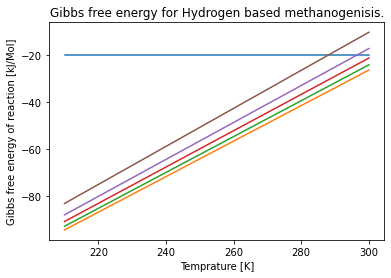

Concentrations for 0.0
[1e-05, 0.1, 0.001, 1.0]
Gives Gibbs energy = 0.7549235429884301 * T + -252.96099999999996
Concentrations for 0.2
[8.000000000000001e-06, 0.0999995, 0.0010005, 1.000001]
Gives Gibbs energy = 0.7623486190901273 * T + -252.96099999999996
Concentrations for 0.4
[6.000000000000001e-06, 0.099999, 0.0010010000000000002, 1.0000019999999998]
Gives Gibbs energy = 0.7719199861745436 * T + -252.96099999999996
Concentrations for 0.6
[4.000000000000001e-06, 0.0999985, 0.0010015000000000002, 1.0000029999999998]
Gives Gibbs energy = 0.7854083438185901 * T + -252.96099999999996
Concentrations for 0.8
[2.0000000000000003e-06, 0.099998, 0.0010020000000000003, 1.0000039999999997]
Gives Gibbs energy = 0.8084638543920057 * T + -252.96099999999996

No concentration for HCO2-(aq) was found. It was set to 1
No concentration for H+(aq)  was found. It was set to 1
For 4*HCO2-(aq) + 4*H+(aq) --> CH4(g) + 3*CO2(g) + 2*H2O(l):


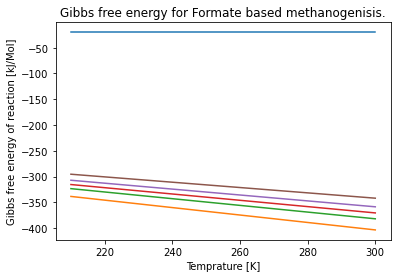

Concentrations for 0.0
[1.0, 1.0, 0.001, 0.1, 1.0]
Gives Gibbs energy = -0.7221336624093034 * T + -186.99699999999996
Concentrations for 0.2
[0.8, 0.8, 0.051000000000000004, 0.25, 1.1]
Gives Gibbs energy = -0.6501637991096312 * T + -186.99699999999996
Concentrations for 0.4
[0.6000000000000001, 0.6000000000000001, 0.101, 0.4, 1.2000000000000002]
Gives Gibbs energy = -0.6121789197429395 * T + -186.99699999999996
Concentrations for 0.6
[0.4000000000000001, 0.4000000000000001, 0.15100000000000002, 0.55, 1.3000000000000003]
Gives Gibbs energy = -0.5725932487814341 * T + -186.99699999999996
Concentrations for 0.8
[0.20000000000000007, 0.20000000000000007, 0.201, 0.7000000000000001, 1.4000000000000004]
Gives Gibbs energy = -0.5168652996836083 * T + -186.99699999999996

No concentration for  C2H5OH(l) was found. It was set to 1
No concentration for  CH3COOH(l) was found. It was set to 1
For 2 * C2H5OH(l) + CO2(g) --> 2 * CH3COOH(l) + CH4(g):


C:\Users\ronal_000\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


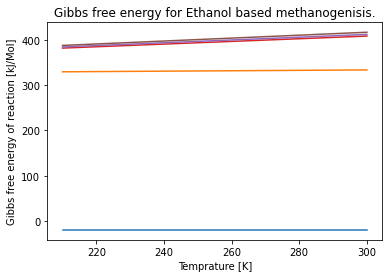

Concentrations for 0.0
[1.0, 0.1, 1.0, 0.001]
Gives Gibbs energy = 0.045898427584176574 * T + 320.117
Concentrations for 0.2
[0.8, 0.0, 1.2, 0.101]
Gives Gibbs energy = inf * T + 320.117
Concentrations for 0.4
[0.6000000000000001, 1e-11, 1.4, 0.201]
Gives Gibbs energy = 0.29551589804382317 * T + 320.117
Concentrations for 0.6
[0.4000000000000001, 1e-11, 1.5999999999999999, 0.30100000000000005]
Gives Gibbs energy = 0.30783556959352526 * T + 320.117
Concentrations for 0.8
[0.20000000000000007, 1e-11, 1.7999999999999998, 0.401]
Gives Gibbs energy = 0.3237045977942751 * T + 320.117

No concentration for CH3OH(l) was found. It was set to 1
For CH3OH(l) + H2(g) --> CH4(g) + H2O(l):


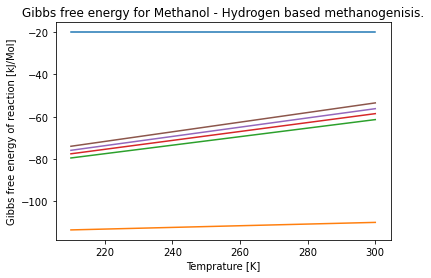

Concentrations for 0.0
[1.0, 1e-05, 0.001, 1.0]
Gives Gibbs energy = 0.03963234551661183 * T + -121.97999999999999
Concentrations for 0.2
[0.8, 1e-11, 0.201, 1.2]
Gives Gibbs energy = 0.20195721420994125 * T + -121.97999999999999
Concentrations for 0.4
[0.6000000000000001, 1e-11, 0.401, 1.4]
Gives Gibbs energy = 0.21137273001341286 * T + -121.97999999999999
Concentrations for 0.6
[0.4000000000000001, 1e-11, 0.601, 1.5999999999999999]
Gives Gibbs energy = 0.21921806989960332 * T + -121.97999999999999
Concentrations for 0.8
[0.20000000000000007, 1e-11, 0.8009999999999999, 1.7999999999999998]
Gives Gibbs energy = 0.2283484733454265 * T + -121.97999999999999

No concentration for  CH3OH(l) was found. It was set to 1
No concentration for C2H5OH(l)  was found. It was set to 1
No concentration for  CH3COOH(l)  was found. It was set to 1
For 2 * CH3OH(l) + C2H5OH(l) --> 2*CH4(g) + H2O(l) +  CH3COOH(l) :


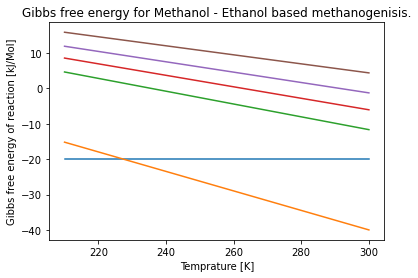

Concentrations for 0.0
[1.0, 1.0, 0.001, 1.0, 1.0]
Gives Gibbs energy = -0.2752478666689031 * T + 42.57900000000001
Concentrations for 0.2
[0.8, 0.9, 0.201, 1.1, 1.1]
Gives Gibbs energy = -0.18089329668947862 * T + 42.57900000000001
Concentrations for 0.4
[0.6000000000000001, 0.8, 0.401, 1.2000000000000002, 1.2000000000000002]
Gives Gibbs energy = -0.16219940925167237 * T + 42.57900000000001
Concentrations for 0.6
[0.4000000000000001, 0.7000000000000001, 0.601, 1.3000000000000003, 1.3000000000000003]
Gives Gibbs energy = -0.14628795933437616 * T + 42.57900000000001
Concentrations for 0.8
[0.20000000000000007, 0.6000000000000001, 0.8009999999999999, 1.4000000000000004, 1.4000000000000004]
Gives Gibbs energy = -0.12747177264656823 * T + 42.57900000000001

No concentration for CH3OH(l)  was found. It was set to 1
For 4*CH3OH(l) --> CO2(g) + 3*CH4(g) + 2*H2O(l):


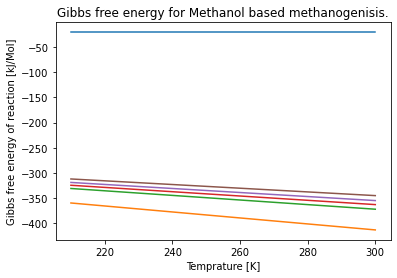

Concentrations for 0.0
[1.0, 0.1, 0.001, 1.0]
Gives Gibbs energy = -0.5963941609219828 * T + -234.959
Concentrations for 0.2
[0.8, 0.15000000000000002, 0.15100000000000002, 1.1]
Gives Gibbs energy = -0.45887645071104205 * T + -234.959
Concentrations for 0.4
[0.6000000000000001, 0.2, 0.30100000000000005, 1.2000000000000002]
Gives Gibbs energy = -0.4282649312491093 * T + -234.959
Concentrations for 0.6
[0.4000000000000001, 0.25, 0.45100000000000007, 1.3000000000000003]
Gives Gibbs energy = -0.40150914382653297 * T + -234.959
Concentrations for 0.8
[0.20000000000000007, 0.3, 0.6010000000000001, 1.4000000000000004]
Gives Gibbs energy = -0.36854821593037307 * T + -234.959

No concentration for CH3COOH(l)  was found. It was set to 1
For CH3COOH(l) --> CO2(g) + CH4(g):


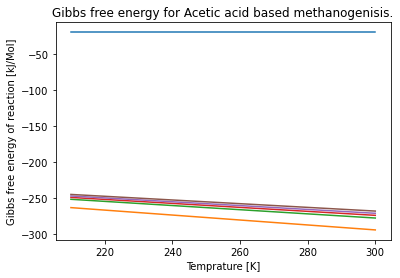

Concentrations for 0.0
[1.0, 0.1, 0.001]
Gives Gibbs energy = -0.3440575805183824 * T + -191.33800000000002
Concentrations for 0.2
[0.8, 0.30000000000000004, 0.201]
Gives Gibbs energy = -0.28897682545916625 * T + -191.33800000000002
Concentrations for 0.4
[0.6000000000000001, 0.5, 0.401]
Gives Gibbs energy = -0.2765959141717881 * T + -191.33800000000002
Concentrations for 0.6
[0.4000000000000001, 0.7, 0.601]
Gives Gibbs energy = -0.2670633241086091 * T + -191.33800000000002
Concentrations for 0.8
[0.20000000000000007, 0.8999999999999999, 0.8009999999999999]
Gives Gibbs energy = -0.25682274066450567 * T + -191.33800000000002

No concentration for  CH3COOH(l) was found. It was set to 1
For 4* CO2(g) + 8* H2(g) --> 2* CH3COOH(l):


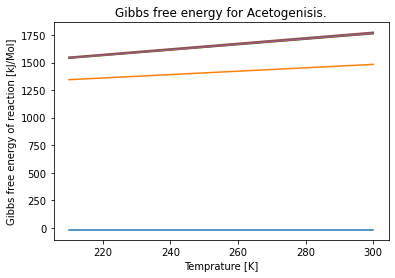

Concentrations for 0.0
[0.1, 1e-05, 1.0]
Gives Gibbs energy = 1.5445864294721197 * T + 1020.0740000000001
Concentrations for 0.2
[0.08, 1e-11, 1.01]
Gives Gibbs energy = 2.4710699837473715 * T + 1020.0740000000001
Concentrations for 0.4
[0.06, 1e-11, 1.02]
Gives Gibbs energy = 2.480800962734082 * T + 1020.0740000000001
Concentrations for 0.6
[0.039999999999999994, 1e-11, 1.03]
Gives Gibbs energy = 2.494447336046319 * T + 1020.0740000000001
Concentrations for 0.8
[0.01999999999999999, 1e-11, 1.04]
Gives Gibbs energy = 2.5176592969376608 * T + 1020.0740000000001

No concentration for SO4-2(aq) was found. It was set to 1
No concentration for  CH2O(aq)  was found. It was set to 1
No concentration for  H2S(g) was found. It was set to 1
No concentration for HCO3-(aq) was found. It was set to 1
For SO4-2(aq) + 2 * CH2O(aq) --> H2S(g) + 2*HCO3-(aq):


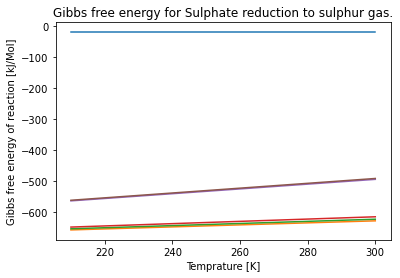

Concentrations for 0.0
[1.0, 1.0, 1.0, 1.0]
Gives Gibbs energy = 0.32510347140701007 * T + -725.5831199999999
Concentrations for 0.2
[0.8, 0.6, 1.2, 1.4]
Gives Gibbs energy = 0.3425633771383398 * T + -725.5831199999999
Concentrations for 0.4
[0.6000000000000001, 0.19999999999999996, 1.4, 1.7999999999999998]
Gives Gibbs energy = 0.36868335609021596 * T + -725.5831199999999
Concentrations for 0.6
[0.4000000000000001, 1e-11, 1.5999999999999999, 2.1999999999999997]
Gives Gibbs energy = 0.7709008259028529 * T + -725.5831199999999
Concentrations for 0.8
[0.20000000000000007, 1e-11, 1.7999999999999998, 2.5999999999999996]
Gives Gibbs energy = 0.7804206750402546 * T + -725.5831199999999

No concentration for Fe2O3(s) was found. It was set to 1
No concentration for  NADH(aq) was found. It was set to 1
No concentration for  H+(aq)  was found. It was set to 1
No concentration for  Fe+2(aq) was found. It was set to 1
No concentration for NAD+(aq) was found. It was set to 1
For Fe2O3(s) + 2* NADH(a

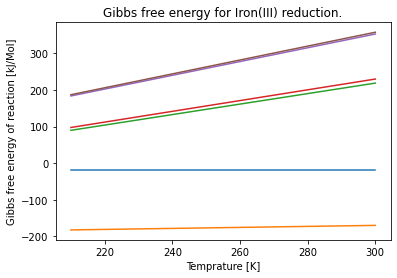

Concentrations for 0.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Gives Gibbs energy = 0.13753010229750082 * T + -211.52839999999992
Concentrations for 0.2
[0.8, 0.6, 1e-11, 1.4, 1.4, 1.6]
Gives Gibbs energy = 1.4342755800448952 * T + -211.52839999999992
Concentrations for 0.4
[0.6000000000000001, 0.19999999999999996, 1e-11, 1.7999999999999998, 1.7999999999999998, 2.2]
Gives Gibbs energy = 1.4712356795197008 * T + -211.52839999999992
Concentrations for 0.6
[0.4000000000000001, 1e-11, 1e-11, 2.1999999999999997, 2.1999999999999997, 2.8000000000000003]
Gives Gibbs energy = 1.8816947856793291 * T + -211.52839999999992
Concentrations for 0.8
[0.20000000000000007, 1e-11, 1e-11, 2.5999999999999996, 2.5999999999999996, 3.4000000000000004]
Gives Gibbs energy = 1.8978558012902491 * T + -211.52839999999992



In [7]:
for i in range(len(reactions)):
    #MRA.plot_for_T(reaction_CH4[i], Tmin = 210, Tmax = 300, warnings = False, title = titles[i])
    #MRA.check_reaction(reaction_other[i])
    MRA.thin_film_simulation(reactions[i], title = titles[i], steps = 5, C_diff = 0.2, Tmin = 210, Tmax = 300, show = 'save')
    

#MRA.define_G(MRA.read_reaction(reaction_CH4[0], 1))
#MRA.check_reaction(reaction_other[i])
#MRA.give_for_T(reaction, T = [308.15])